In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers


In [2]:
# Load dataset
data = fetch_california_housing()
X, y = data.data, data.target

# Train/Validation/Test split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)


In [3]:
def build_model(input_dim, lr, num_layers, neurons, dropout, weight_decay):
    model = models.Sequential()
    model.add(layers.Input(shape=(input_dim,)))

    for _ in range(num_layers):
        model.add(layers.Dense(
            neurons,
            activation='relu',
            kernel_regularizer=tf.keras.regularizers.l2(weight_decay)
        ))
        model.add(layers.Dropout(dropout))

    model.add(layers.Dense(1))

    optimizer = optimizers.Adam(learning_rate=lr)
    model.compile(
        optimizer=optimizer,
        loss='mse',
        metrics=['mae']
    )
    return model


In [ ]:
import random

def sample_config():
    return {
        "lr": 10 ** random.uniform(-5, -2),
        "batch_size": ([16,32]),
        "num_layers": random.randint(6, 10),
        "neurons": random.choice([32, 64, 128, 256]),
        "dropout": random.uniform(0.0, 0.5),
        "weight_decay": 10 ** random.uniform(-6, -2)
    }


In [5]:
configs = [sample_config() for _ in range(64)]
history_store = {}
results = []

epochs_schedule = [5, 15, 30]

for stage, epochs in enumerate(epochs_schedule):
    print(f"\nStage {stage+1} - Training for {epochs} epochs")

    stage_results = []

    for i, cfg in enumerate(configs):
        model = build_model(
            X_train.shape[1],
            cfg["lr"],
            cfg["num_layers"],
            cfg["neurons"],
            cfg["dropout"],
            cfg["weight_decay"]
        )

        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=32,
            verbose=0
        )

        val_loss = history.history["val_loss"][-1]
        stage_results.append((cfg, val_loss, history))
        history_store[str(cfg)] = history

    stage_results.sort(key=lambda x: x[1])
    configs = [cfg for cfg, _, _ in stage_results[:len(stage_results)//2]]



Stage 1 - Training for 5 epochs

Stage 2 - Training for 15 epochs

Stage 3 - Training for 30 epochs


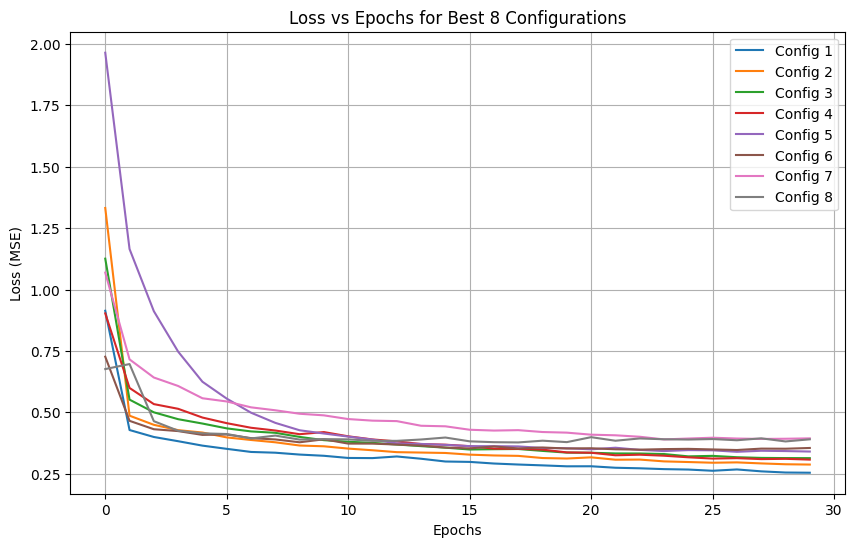

In [6]:
best_8 = stage_results[:8]

plt.figure(figsize=(10,6))
for i, (cfg, _, hist) in enumerate(best_8):
    plt.plot(hist.history['loss'], label=f'Config {i+1}')

plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.title("Loss vs Epochs for Best 8 Configurations")
plt.legend()
plt.grid(True)
plt.show()


In [8]:
def evaluate_model(cfg):
    model = build_model(
        X_train.shape[1],
        cfg["lr"],
        cfg["num_layers"],
        cfg["neurons"],
        cfg["dropout"],
        cfg["weight_decay"]
    )

    # ⚠️ Batch size fixed to 32 to avoid retraining SHA
    model.fit(
        X_train,
        y_train,
        epochs=30,
        batch_size=32,
        verbose=0
    )

    preds = model.predict(X_test).flatten()

    return {
        "R2": r2_score(y_test, preds),
        "MAE": mean_absolute_error(y_test, preds),
        "MSE": mean_squared_error(y_test, preds)
    }


In [9]:
metrics_table = []

for i, (cfg, _, _) in enumerate(best_8):
    metrics = evaluate_model(cfg)
    metrics_table.append([
        i + 1,
        "MSE",
        metrics["R2"],
        metrics["MAE"],
        metrics["MSE"]
    ])

metrics_df = pd.DataFrame(
    metrics_table,
    columns=["Configuration #", "Loss Function", "R² Score", "MAE", "MSE"]
)

metrics_df


97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


,Configuration #,Loss Function,R² Score,MAE,MSE
0,1,MSE,0.811870,0.342217,0.248766
1,2,MSE,0.816442,0.334882,0.242721
2,3,MSE,0.807883,0.348576,0.254039
3,4,MSE,0.809126,0.366351,0.252394
4,5,MSE,0.776863,0.371040,0.295057
5,6,MSE,0.756096,0.424117,0.322517
6,7,MSE,0.782363,0.392680,0.287784
7,8,MSE,0.768226,0.391195,0.306477


In [10]:
best_4 = best_8[:4]

hp_table = []
for i, (cfg, _, _) in enumerate(best_4):
    hp_table.append([
        i+1,
        cfg["lr"],
        cfg["batch_size"],
        cfg["num_layers"],
        cfg["neurons"],
        cfg["dropout"],
        cfg["weight_decay"]
    ])

hp_df = pd.DataFrame(
    hp_table,
    columns=[
        "Configuration #",
        "Learning rate",
        "Batch size",
        "Hidden layers",
        "Neurons per layer",
        "Dropout rate",
        "Weight decay"
    ]
)
hp_df


,Configuration #,Learning rate,Batch size,Hidden layers,Neurons per layer,Dropout rate,Weight decay
0,1,0.000211,[16],6,256,0.029278,0.000010
1,2,0.000228,[16],6,256,0.127980,0.000004
2,3,0.000197,[16],6,256,0.187060,0.000006
3,4,0.000684,[16],10,256,0.137120,0.000067


Hyperparameter tuning significantly improves model performance. Random search combined with successive halving efficiently explored the search space while reducing computational cost.

Lower learning rates, deeper networks, and moderate regularization consistently produced better generalization performance.